In [1]:
import zipfile

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import pandas as pd
from lightgbm import LGBMClassifier

In [2]:
import os
from copy import copy
from itertools import product
import pprint
import shutil
import time
from typing import Dict

import matplotlib.pyplot as plt
import mlflow
import numpy as np
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split

In [3]:
# create an experiment in MLflow

# we'll make the name unique in the project by appending a timestamp so that you and other users can run this cell more than once.
timestamp = time.time()
username = os.environ['DOMINO_STARTING_USERNAME']
experiment_name = f"census-classifier-{timestamp}"
# below, we'll use the returned experiment_id in calls to mlflow.start_run() to add data to the experiment.
experiment_id = mlflow.create_experiment(experiment_name)
print(f"Experiment id: {experiment_id}")
print(f"Experiment name: {experiment_name}")

Experiment id: 229
Experiment name: census-classifier-1683927242.658779


In [4]:
!pip install raiutils

from raiutils.dataset import fetch_dataset
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def split_label(dataset, target_feature):
    X = dataset.drop([target_feature], axis=1)
    y = dataset[[target_feature]]
    return X, y

def create_classification_pipeline(X):
    pipe_cfg = {
        'num_cols': X.dtypes[X.dtypes == 'int64'].index.values.tolist(),
        'cat_cols': X.dtypes[X.dtypes == 'object'].index.values.tolist(),
    }
    num_pipe = Pipeline([
        ('num_imputer', SimpleImputer(strategy='median')),
        ('num_scaler', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('cat_imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    feat_pipe = ColumnTransformer([
        ('num_pipe', num_pipe, pipe_cfg['num_cols']),
        ('cat_pipe', cat_pipe, pipe_cfg['cat_cols'])
    ])

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    pipeline = Pipeline(steps=[('preprocessor', feat_pipe),
                               ('model', LGBMClassifier(random_state=0))])

    return pipeline

outdirname = 'responsibleai.12.28.21'
zipfilename = outdirname + '.zip'

fetch_dataset('https://publictestdatasets.blob.core.windows.net/data/' + zipfilename, zipfilename)

with zipfile.ZipFile(zipfilename, 'r') as unzip:
    unzip.extractall('.')

target_feature = 'income'
categorical_features = ['workclass', 'education', 'marital-status',
                        'occupation', 'relationship', 'race', 'gender', 'native-country']


train_data = pd.read_csv('adult-train.csv', skipinitialspace=True)
test_data = pd.read_csv('adult-test.csv', skipinitialspace=True)

X_train_original, y_train = split_label(train_data, target_feature)
X_test_original, y_test = split_label(test_data, target_feature)

pipeline = create_classification_pipeline(X_train_original)

y_train = y_train[target_feature].to_numpy()
y_test = y_test[target_feature].to_numpy()


# Take 500 samples from the test data
test_data_sample = test_data.sample(n=500, random_state=5)

Dataset download attempt 1 of 4


## Create a custom model type

In [5]:
class CensusModel(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        temp = tempfile.TemporaryDirectory()
        mlflow.artifacts.download_artifacts(artifact_uri=context.artifacts['model_file'], dst_path=temp.name)
        self.model = mlflow.load_model(model_uri=model_info.model_uri)
    
    def predict(self, context, model_input):
        print(f"model_input: {model_input}")
        return self.model.predict(pd.DataFrame(model_input))

Finished predictions.
Run: victorious-fawn-228

Classification report:
              precision    recall  f1-score   support

       <=50K      0.899     0.943     0.920     12435
        >50K      0.780     0.656     0.713      3846

    accuracy                          0.875     16281
   macro avg      0.839     0.799     0.816     16281
weighted avg      0.870     0.875     0.871     16281




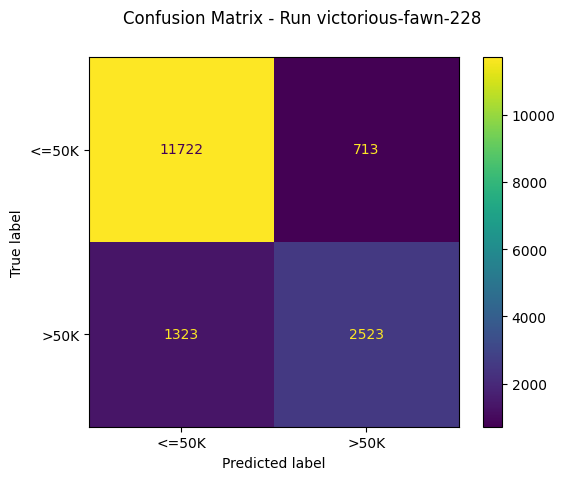

Recording run params, metrics, and artifacts to MLflow...
{'<=50K': {'precision': 0.8985818321195861, 'recall': 0.9426618415761963, 'f1-score': 0.920094191522763, 'support': 12435}, '>50K': {'precision': 0.7796662546353523, 'recall': 0.65600624024961, 'f1-score': 0.7125105902287491, 'support': 3846}, 'accuracy': 0.8749462563724587, 'macro avg': {'precision': 0.8391240433774692, 'recall': 0.799334040912903, 'f1-score': 0.8163023908757561, 'support': 16281}, 'weighted avg': {'precision': 0.8704908480888532, 'recall': 0.8749462563724587, 'f1-score': 0.8710574904247483, 'support': 16281}}


2023/05/12 21:42:37 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpu8ixe30b/model, flavor: python_function), fall back to return ['cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


model uri: runs:/3bbd6429a6224651a76e3e15ae0a21f6/Income Census Classifier


In [8]:
model_name = "Income Census Classifier"

run_name=None
with mlflow.start_run(experiment_id=experiment_id, run_name=None) as run:
    if run_name is None:
        run_name = run.info.run_name
            
    model = pipeline.fit(X_train_original, y_train)

    # Testing
    predicted = model.predict(X_test_original)
    prediction_report_str = metrics.classification_report(y_test, predicted, digits=3, output_dict=False)
    prediction_report_dict = metrics.classification_report(y_test, predicted, output_dict=True)
    
    # print some info about the run and also save as file for an MLflow artifact
    print("Finished predictions.")
    run_overview = (
            f"Run: {run_name}\n"            
            "\n"
            "Classification report:\n"
            f"{prediction_report_str}\n"
    )
    print(f"{run_overview}")
    run_overview_file_name = "run_overview.txt"
    with open(run_overview_file_name, "w") as f:
        f.write(run_overview)
    
    # visualize model performance and save visualization for an MLflow artifact
    disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
    disp.figure_.suptitle(f"Confusion Matrix - Run {run_name}")
    confusion_matrix_file_name = f"confusion_matrix_run_{run_name}.png"
    plt.savefig(confusion_matrix_file_name)
    plt.show()

    print("Recording run params, metrics, and artifacts to MLflow...")
    # record notable sklearn model params and performance metrics.
    # this enables visual comparison via the Experiments UI.
    #for param, val in svc_param_kwargs.items():
    #    mlflow.log_param(param, val)
    # record metrics for each individual digit as well as overall averages
    print(prediction_report_dict)
    for metric in ("precision", "recall", "f1-score"):
        for digit in {"<=50K", ">50K"}:
            mlflow.log_metric(f"{metric}", prediction_report_dict[digit][metric])
        for avg_type in ("macro", "weighted"):
            mlflow.log_metric(f"{metric}_{avg_type}_avg", prediction_report_dict[f"{avg_type} avg"][metric])
    mlflow.log_metric("overall_accuracy", prediction_report_dict["accuracy"])

    # record the data for reproducibility
    #data_dir_name = "run_data_"+f"{experiment_id}"
    #os.mkdir(data_dir_name)
    
    #for data, data_name in ((X_train_original, "train_x"), (y_train, "train_y"), (X_test_original, "test_x"), (y_test, "test_y")):
    #    with open(os.path.join(data_dir_name, f"{data_name}.csv"), "w") as data_file:
    #        np.savetxt(data_file, data, delimiter=",")
    #    mlflow.log_artifact(data_dir_name)
    #    shutil.rmtree(data_dir_name)

    # record human-readable/interpretable overview and figures
    mlflow.log_artifact(run_overview_file_name)
    mlflow.log_artifact(confusion_matrix_file_name)

    py_model = CensusModel()
    
    # record the trained sklearn model
    #model_info = mlflow.sklearn.log_model(model, "model")    
    # (Include `registered_model_name` to register directly in the registry and skip step #3)
    model_info = mlflow.pyfunc.log_model(
        artifact_path=model_name,
        python_model=py_model,
        #pip_requirements="requirements.txt",
    )
    print(f"model uri: {model_info.model_uri}")

## Add the model to the registry

In [10]:
import mlflow.sklearn
from mlflow.store.artifact.runs_artifact_repo import RunsArtifactRepository
from mlflow import MlflowClient

# Register model name in the model registry
client = MlflowClient()
try:
  client.create_registered_model(model_name)
except:
  print(f"model {model_name} already registered")

# Create a new version of the rfr model under the registered model name
desc = "LGBM model to classify census entries into income brackets"
#runs_uri = "runs:/{}/sklearn-model".format(run.info.run_id)
#model_src = RunsArtifactRepository.get_underlying_uri(runs_uri)
#mv = client.create_model_version(name, model_src, run.info.run_id, description=desc)
mv = client.create_model_version(model_name, model_info.model_uri, run.info.run_id, description=desc)
#mv = mlflow.register_model(model_info.model_uri, name, description=desc)
print("Name: {}".format(mv.name))
print("Version: {}".format(mv.version))
print("Description: {}".format(mv.description))
print("Status: {}".format(mv.status))
print("Stage: {}".format(mv.current_stage))

2023/05/12 21:43:09 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Income Census Classifier, version 2


model Income Census Classifier already registered
Name: Income Census Classifier
Version: 2
Description: LGBM model to classify census entries into income brackets
Status: READY
Stage: None


## Save a copy of the model to the project

In [ ]:
import pickle

# dump the model into a file
with open("../artifacts/model.bin", 'wb') as f_out:
    pickle.dump(model, f_out)
    f_out.close()

## Record the training data as a training set

In [ ]:
from domino.training_sets import TrainingSetClient, model
import pandas as pd
import numpy as np
import os
import random
 
# defining the column names
cols = categorical_features
# pare down data
#df = df[["mpg", "displacement", "horsepower", "weight", "origin"]]
training_df = train_data.copy()
#df_training_set.reset_index(inplace=True)
#df_training_set.rename(columns={'index':'customer_id'}, inplace=True)
 
tsv = TrainingSetClient.create_training_set_version(
    training_set_name="census-training-data-{}-{}".format(os.environ['DOMINO_PROJECT_OWNER'], os.environ['DOMINO_PROJECT_ID']),
    df=training_df,
    #key_columns=['customer_id'],
    target_columns=["income"],
    exclude_columns=[],
    meta={"meta_data": "1"},
    monitoring_meta=model.MonitoringMeta(**{
        "categorical_columns": cols,
        "timestamp_columns": [],
        "ordinal_columns": []
    }),
    project_name=os.environ['DOMINO_PROJECT_NAME']
)
 
print(f"TrainingSetVersion {tsv.training_set_name}:{tsv.number}")

## Test the prediction code

In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from domino_data_capture.data_capture_client import DataCaptureClient
import datetime
import uuid
 
feature_names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "native-country"]
predict_names = ['income']
pred_client = DataCaptureClient(feature_names, predict_names)
 
 
with open("../artifacts/model.bin", 'rb') as f_in:
    loaded_model = pickle.load(f_in)
    f_in.close()  # close the file 
 
def predict(age, workclass, fnlwgt, education, education_num, marital_status, occupation, relationship, race, gender, capital_gain, capital_loss, hours_per_week, native_country, census_id=None):
    transformed_data = pd.DataFrame([[age, workclass, fnlwgt, education, education_num, marital_status, occupation, relationship, race, gender, capital_gain, capital_loss, hours_per_week, native_country]],columns=["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "native-country"])
    prediction = loaded_model.predict(transformed_data)
    
    if census_id is None:
        print(f"No Customer ID found! Creating a new one.")
        census_id = str(uuid.uuid4())
    
    feature_array = list([age, workclass, fnlwgt, education, education_num, marital_status, occupation, relationship, race, gender, capital_gain, capital_loss, hours_per_week, native_country])
    pred_array = list(prediction)
    
    pred_client.capturePrediction(feature_array, prediction, event_id=census_id)
    
    return dict(prediction=prediction[0])
    
predict(25, "Private", 226802, "11th", 7, "Never-married", "Machine-op-inspct", "Own-child", "Black", "Male", 0, 0, 40, "United-States")

## Test the Model API

In [ ]:
import pandas as pd
import requests

model_url = "https://rev4demo12597.product-team-sandbox.domino.tech:443/models/645c2e1355d999335fadfd65/latest/model"

def split_label(dataset, target_feature):
    X = dataset.drop([target_feature], axis=1)
    y = dataset[[target_feature]]
    return X, y


target_feature = 'income'
test_data = pd.read_csv('./adult-test.csv', skipinitialspace=True)
X_test_original, y_test = split_label(test_data, target_feature)
X_test_sample = X_test_original.sample(n=1, random_state=5)

X_test_sample_dict = X_test_sample.to_dict(orient='records')

columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country"
]

for record in X_test_sample_dict:
    send_record = {"data": dict(zip(columns, list(record.values())))}
    #send_record = {'columns': columns, 'data': record.values()}
    print(f"posting: {send_record}")
    response = requests.post(model_url,
        auth=(
            "vExqOWFGYJsOjAe3MQUpeg9lug1bUGzQX6nnKqwsjTNmQfYerR4tB9SeF5cNqAP9",
            "vExqOWFGYJsOjAe3MQUpeg9lug1bUGzQX6nnKqwsjTNmQfYerR4tB9SeF5cNqAP9"
        ),
        json=send_record
    )
 
    print(response.status_code)
    print(response.headers)
    print(response.json())
    #print(send_record)

## RAI Dashboard

In [ ]:
!pip install raiwidgets --user
!pip install responsibleai --user

In [ ]:
from raiwidgets import ResponsibleAIDashboard
from responsibleai import RAIInsights

from responsibleai.feature_metadata import FeatureMetadata
feature_metadata = FeatureMetadata(categorical_features=categorical_features, dropped_features=[])

rai_insights = RAIInsights(model, train_data, test_data_sample, target_feature, 'classification',
                           feature_metadata=feature_metadata)

# Interpretability
rai_insights.explainer.add()
# Error Analysis
rai_insights.error_analysis.add()
# Counterfactuals: accepts total number of counterfactuals to generate, the label that they should have, and a list of 
                # strings of categorical feature names
rai_insights.counterfactual.add(total_CFs=10, desired_class='opposite')

rai_insights.compute()

from raiutils.cohort import Cohort, CohortFilter, CohortFilterMethods

# Cohort on age and hours-per-week features in the dataset
cohort_filter_age = CohortFilter(
    method=CohortFilterMethods.METHOD_LESS,
    arg=[65],
    column='age')
cohort_filter_hours_per_week = CohortFilter(
    method=CohortFilterMethods.METHOD_GREATER,
    arg=[40],
    column='hours-per-week')

user_cohort_age_and_hours_per_week = Cohort(name='Cohort Age and Hours-Per-Week')
user_cohort_age_and_hours_per_week.add_cohort_filter(cohort_filter_age)
user_cohort_age_and_hours_per_week.add_cohort_filter(cohort_filter_hours_per_week)

# Cohort on marital-status feature in the dataset
cohort_filter_marital_status = CohortFilter(
    method=CohortFilterMethods.METHOD_INCLUDES,
    arg=["Never-married", "Divorced"],
    column='marital-status')

user_cohort_marital_status = Cohort(name='Cohort Marital-Status')
user_cohort_marital_status.add_cohort_filter(cohort_filter_marital_status)

# Cohort on index of the row in the dataset
cohort_filter_index = CohortFilter(
    method=CohortFilterMethods.METHOD_LESS,
    arg=[20],
    column='Index')

user_cohort_index = Cohort(name='Cohort Index')
user_cohort_index.add_cohort_filter(cohort_filter_index)

# Cohort on predicted target value
cohort_filter_predicted_y = CohortFilter(
    method=CohortFilterMethods.METHOD_INCLUDES,
    arg=['>50K'],
    column='Predicted Y')

user_cohort_predicted_y = Cohort(name='Cohort Predicted Y')
user_cohort_predicted_y.add_cohort_filter(cohort_filter_predicted_y)

# Cohort on predicted target value
cohort_filter_true_y = CohortFilter(
    method=CohortFilterMethods.METHOD_INCLUDES,
    arg=['>50K'],
    column='True Y')

user_cohort_true_y = Cohort(name='Cohort True Y')
user_cohort_true_y.add_cohort_filter(cohort_filter_true_y)

cohort_list = [user_cohort_age_and_hours_per_week,
               user_cohort_marital_status,
               user_cohort_index,
               user_cohort_predicted_y,
               user_cohort_true_y]

ResponsibleAIDashboard(rai_insights, cohort_list=cohort_list)